### 모듈 임포트

In [477]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

### 이미지 가져오기

이번 Exploration 노드에서 사용할 이미지들을 가져와보겠습니다.

#### os 모듈사용

In [478]:
face_images = []
sticker_images = []
my_image_path = os.getenv("HOME") + '/aiffel/exploration-3-camera-sticker/data/gini/'
files = os.listdir(my_image_path)

for file in files:
    
    if file == ".ipynb_checkpoints":
        continue
        
    if 'sticker' in file: ## 스티커 이미지
        file = os.path.join(my_image_path, file)
        f = cv2.imread(file)
        # f = cv2.resize(f, (640, 480))
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        len
        sticker_images.append(f)
        
    else: ## 일반 이미지
        file = os.path.join(my_image_path, file)
        f = cv2.imread(file)
        f = cv2.resize(f, (300, 390)) ## 해상도를 크게하면 검출이 될 수 있다.
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        face_images.append(f)


이미지를 원하는대로 4장의 사진과 1장의 스티커 사진을 제대로 불러왔습니다. 스티커 사진은 나중에 resizing을 하기 때문에 별도로 리사이징을 하지 않았습니다.

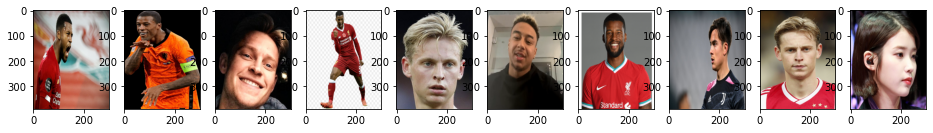

In [479]:
fig, axes = plt.subplots(nrows=1,ncols=len(face_images), figsize=(16, 30))
axs = axes.ravel()
for i in range(len(face_images)):
    axs[i].imshow(face_images[i])

In [480]:
len(sticker_images)

3

In [481]:
## 원본저장
import copy
ori_face_images = copy.deepcopy(face_images)
print(id(face_images))
print(id(ori_face_images))

140137821897584
140136435825232


### 얼굴 검출

In [482]:
import dlib
detector_hog = dlib.get_frontal_face_detector()

0
rectangles[]
1
rectangles[[(26, 26) (116, 116)]]
2
rectangles[[(56, 139) (242, 325)]]
3
rectangles[[(117, 30) (153, 66)]]
4
rectangles[[(77, 160) (262, 345)]]
5
rectangles[[(67, 82) (196, 211)]]
6
rectangles[[(96, 66) (185, 156)]]
7
rectangles[]
8
rectangles[[(81, 116) (236, 270)]]
9
rectangles[[(118, 118) (304, 304)]]


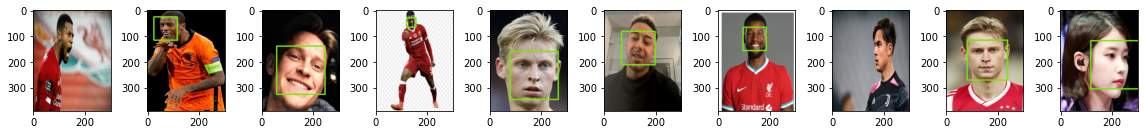

In [483]:
fig, axes = plt.subplots(nrows=1,ncols=len(face_images), figsize=(16, 30))
axs = axes.ravel()
## 정해지지 않은 subplots 갯수를 어떻게 처리할 수 있을까?
face_rects = []
for i, img in enumerate(face_images):
    print(i)
    dlib_rects = detector_hog(img, 1)
    face_rects.append(dlib_rects)
    print(dlib_rects)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img, (l,t), (r,b), (121,229,14), 3,
                      lineType=cv2.LINE_AA)

    axs[i].imshow(img)

plt.tight_layout()

첫번째, 여덟번째 사진은 얼굴을 찾지 못했기 때문에 나머지 사진만 사용하도록 하겠습니다.

In [484]:
## 얼굴을 찾은 사진만 사용하기.
face_rects = []
detected_faces = []
ori_detected_faces = []
for i, img in enumerate(face_images):
    dlib_rects = detector_hog(img, 1)
    if len(dlib_rects):
        ori_detected_faces.append(ori_face_images[i])
        detected_faces.append(face_images[i])
        face_rects.append(dlib_rects)

print(len(face_rects))
print(len(detected_faces))

7
7


In [485]:
## 원본저장
print(id(ori_detected_faces))
print(id(detected_faces))

140136445810320
140136438470688


### 랜드마크 찾기

우선 얼굴의 랜드마크를 찾기위해 lib에서 제공하는 pretrained 모델을 사용해보겠습니다.

In [486]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

이미지별 찾은 얼굴을 표시하는 박스를 딕셔너리 형태로 저장하겠습니다. 이 때 key는 이미지의 인덱스, value는 박스의 좌표값으로 지정하겠습니다.

In [487]:
rects_dict = {k: v for k, v in enumerate(face_rects)}

In [488]:
length = len(rects_dict)
print(length)

7


여러개의 이미지에 적용하기 위해 얼굴의 랜드마크를 찾는 함수를 만들어서 사용하겠습니다.

In [489]:
def find_landmarks(img, dlib_rects):
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    return list_landmarks

이미지별 찾은 얼굴을 표시하는 박스를 딕셔너리 형태로 저장하겠습니다. 이 때 key는 이미지의 인덱스, value는 landmark 좌표값으로 지정하겠습니다.

In [490]:
landmark_dict = {k: [] for k in range(0, length)}
for k, v in rects_dict.items():
    if len(v):
        img = detected_faces[k]
        dlib_rects = v
        landmark_list = find_landmarks(img, dlib_rects)
        landmark_dict[k] = landmark_list

랜드마크를 찾은 형태를 한번 확인해보겠습니다.

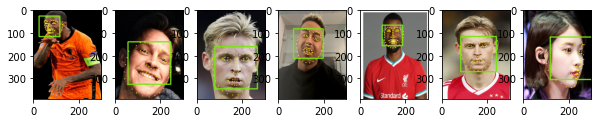

In [491]:
fig, axes = plt.subplots(nrows=1, ncols=length, figsize=(10,30))
axs = axes.ravel()
for k, v in landmark_dict.items():
## 얼굴은 찾고 랜드마크를 못 찾을 수 있나?
    for landmark in v:
        for point in landmark:
            img = detected_faces[k]
            cv2.circle(img, point, 2, (255, 255, 0), -1)
                
    axs[k].imshow(img)

### 스티커 사진 적용하기

수염을 붙여보겠습니다.

수염은 코와 입 사이에 있으므로 코의 양쪽 끝과 입술의 양쪽 끝의 좌표를 얻어보겠습니다.

In [492]:
coord_per_landmark = {k: {} for k in range(0, length)}

In [493]:
def nose_lips_coordinates(landmarks):
    for landmark in landmarks:
        coordinate_dict = {"l_nose": (), "r_nose": (), "l_lips": (), "r_lips": ()}

        l_nose_x = landmark[31][0]
        l_nose_y = landmark[31][1]
        coordinate_dict["l_nose"] = (l_nose_x, l_nose_y)

        r_nose_x = landmark[35][0]
        r_nose_y = landmark[35][1]
        coordinate_dict["r_nose"] = (r_nose_x, r_nose_y)

        l_lips_x = landmark[48][0]
        l_lips_y = landmark[48][1]
        coordinate_dict["l_lips"] = (l_lips_x, l_lips_y)

        r_lips_x = landmark[54][0]
        r_lips_y = landmark[54][1]
        coordinate_dict["r_lips"] = (r_lips_x, r_lips_y)
    
    return coordinate_dict

In [494]:
for k in range(0, length):
    coordinate_dict = nose_lips_coordinates(landmark_dict[k])
    coord_per_landmark[k] = coordinate_dict

In [495]:
coord_per_landmark[0]

{'l_nose': (62, 78),
 'r_nose': (80, 79),
 'l_lips': (62, 90),
 'r_lips': (93, 90)}

스티커의 사이즈를 코와 입술사이의 간격에 맞게 수정해보겠습니다. 코와 입술사이의 간격에만 맞추면 지나치게 작아지는 것 같아 약간의 보정을 해주겠습니다.

In [496]:
sticker_size = {k: () for k in range(0, length)}
for k, v in coord_per_landmark.items():
    if len(v):
        s_width = v["r_lips"][0] - v["l_lips"][0] + 5
        s_height = v["l_lips"][1] - v["l_nose"][1] + 5
        sticker_size[k] = (s_width, s_height)

In [497]:
sticker_dict = {k: [] for k in range(0, length)}
for k, v in sticker_size.items():
    re_sticker_imgs = [cv2.resize(img, (v[0], v[1])) for img in sticker_images]
    sticker_dict[k] = np.array(re_sticker_imgs)

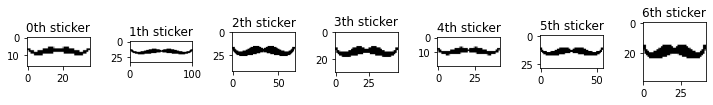

In [498]:
fig, axes = plt.subplots(nrows=1, ncols=length, figsize=(10, 10))
axs = axes.ravel()
for i in range(0, length):
    axs[i].imshow(sticker_dict[i][1]) ## 1 하면 다른 스티커
    axs[i].set_title(f"{i}th sticker")
        
plt.tight_layout()

### 스티커 회전 시키기

스티커를 얼굴이 돌아간만큼 미리 회전을 시켜주겠습니다.

In [499]:
def rotate_image(image, angle, clockwise=True):
    if not clockwise:
        angle = 360-angle
    
    #add_height = (landmark[51][1] - landmark[33][1])//2
    ## 코와 입사이
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    
    abs_cos = abs(rot_mat[0,0])
    abs_sin = abs(rot_mat[0,1])
    
    height, width = image.shape[:2]
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)
    
    rot_mat[0, 2] += bound_w/2 - image_center[0]
    rot_mat[1, 2] += bound_h/2 - image_center[1]
    
    result = cv2.warpAffine(image, rot_mat, ((bound_w, bound_h)), 
                            borderValue=(255,255,255))
    
    return result

In [500]:
rot_sticker_dict = {k: [] for k in range(0, length)}
for i, coord in enumerate(coord_per_landmark.values()):

    temp_image = sticker_dict[i][1]

    x1 = coord["l_lips"][0]
    x2 = coord["r_lips"][0]

    y1 = coord["l_lips"][1]
    y2 = coord["r_lips"][1]
    if y2 >= y1:
        clockwise = False
    else:
        clockwise = True

    x = abs(x2-x1)
    y = abs(y1-y2)
    
    angle = np.arctan(y/x) / np.pi * 180
    
    if angle:
        rot_sticker_dict[i] = rotate_image(temp_image, angle, clockwise=clockwise)
    else:
        rot_sticker_dict[i] = temp_image

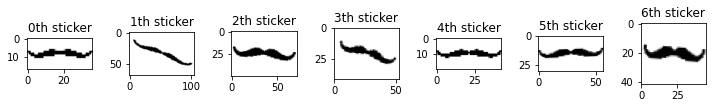

In [501]:
fig, axes = plt.subplots(nrows=1, ncols=length, figsize=(10, 10))
axs = axes.ravel()
for i in range(0, length):
    if len(rot_sticker_dict[i]):
        axs[i].imshow(rot_sticker_dict[i])
        axs[i].set_title(f"{i}th sticker")
        
plt.tight_layout()

In [502]:
import copy
sample_faces = copy.deepcopy(ori_detected_faces)

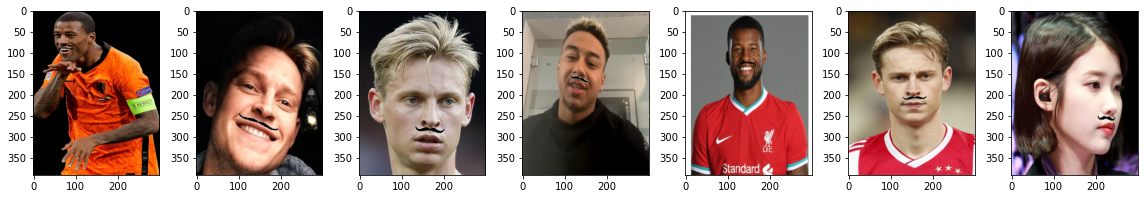

In [503]:
fig, axes = plt.subplots(nrows=1, ncols=length, figsize=(16, 16))
axs = axes.ravel()
for k, v in coord_per_landmark.items():
    if len(v):
        
        h = (v["l_lips"][1] - v["l_nose"][1]) // 3
        x_start = v["l_lips"][0]
        y_start = v["l_nose"][1] - h
        
        sticker = rot_sticker_dict[k] ## 1 하면 다른 스티커
        img = sample_faces[k]
        
        sticker_area = img[y_start:y_start+sticker.shape[0], x_start:x_start+sticker.shape[1]]
        
        img[y_start:y_start+sticker.shape[0], x_start:x_start+sticker.shape[1]] = \
    np.where(sticker==255,sticker_area,sticker).astype(np.uint8)
        
        axs[k].imshow(img)
        
fig.tight_layout()


### 소감 및 TODO
1. 다양한 사람이 있을 때 처리할 수 있도록 처리해보기
2. 정면을 보면서 옆이 아니라 아얘 옆으로 보고 있을 때는 PerspectiveTransformation을 이용해서 처리해보기

CV2를 많이 이용해보게 되서 재밌었습니다. 회전변환이나 투영변환도 결국 Affine map을 잘 구해서 이동시키면 되는 것을 알게 됐는데 계산이 귀찮고 시간이 부족해 완벽하게 구현은 못해 아쉽습니다.